In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import glob
from PIL import Image

The idea behind this notebook is to build EFIT from the ground up by starting with 1D case up to 3D. The equations for the 1D and 2D cases can be derived by simplifying the 3D equations. 

The 3D equations can be found from a variety of sources: Hinder's scattering book, Computational NDE Handbook by Leckey, or the original paper by Felinger. Here is a screenshots from the computational NDE handbook chapter 8:


## change in velocity
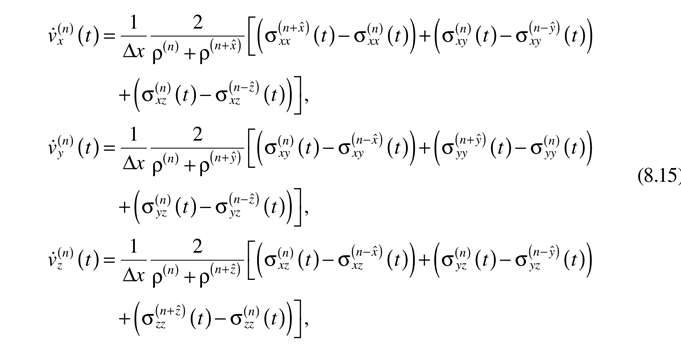

## change in stress
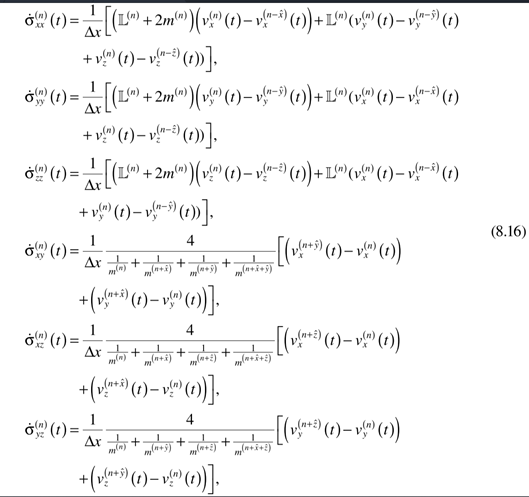

## update rules
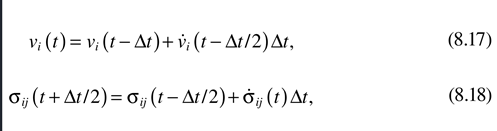

## boundary conditions
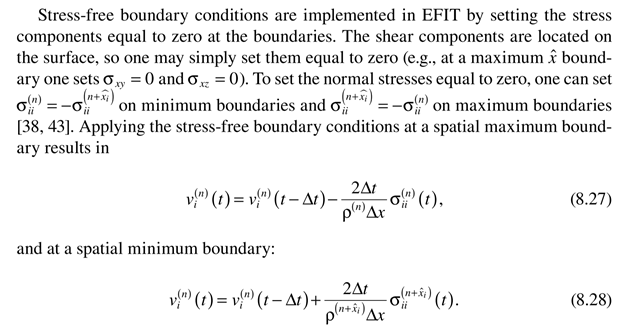

## stability conditions
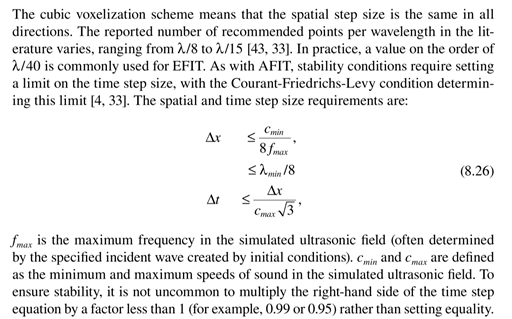

## general procedure 

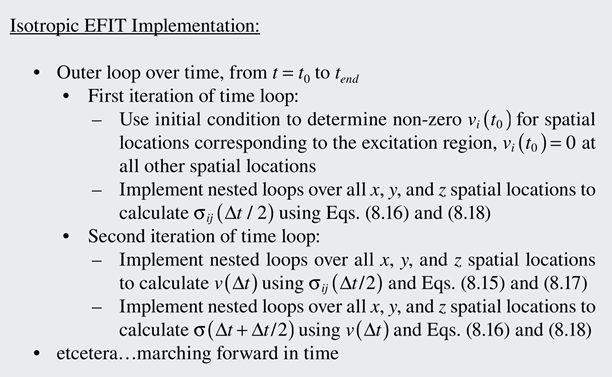

# 2D EFIT
From here, let's reduce the finite difference equations down to 2D by setting all z values to zero. The resulting FD equations are

## change in velocity


$$
\dot{v}_x=\frac{1}{\Delta x} \frac{2}{\rho ^n +\rho ^{n+x}} [(\sigma_{xx} ^{n+x}-\sigma_{xx} ^n)+(\sigma_{xy}^n -\sigma_{xy}^{n-y})]
$$
$$
\dot{v}_y=\frac{1}{\Delta x} \frac{2}{\rho ^n +\rho ^{n+y}} [(\sigma_{xy}^n-\sigma_{xy}^{n-x})+(\sigma_{yy}^{n+y}-\sigma_{yy}^n)]
$$


## change in stress

$$
\dot{\sigma}_{xx}=\frac{1}{\Delta x}[(L^n+2m^n)(v_x^n-v_x^{n-x})+L^n (v_y^n-v_y^{n-y})]
$$
$$
\dot{\sigma}_{yy}=\frac{1}{\Delta x}[(L^n+2m^n)(v_y^n-v_y^{n-y})+L^n(v_x^n-v_x^{n-x})]
$$
$$
\dot{\sigma}_{xy}=\frac{1}{\Delta x}\frac{4}{\frac{1}{m^n}+\frac{1}{m^{n+x}}+\frac{1}{m^{n+y}}+\frac{1}{m^{n+x+y}}}[(v_x^{n+y}-v_x^n)+(v_y^{n+x}-v_y^n)]
$$

# 1D EFIT 
We can reduce the 2D equations again to obtain the 1D equations.
## change in velocity
$$
\dot{v}_x=\frac{1}{\Delta x}\frac{2}{\rho^n +\rho^{n+x}}(\sigma_x^{n+x}-\sigma_x^n)
$$

## change in stress
$$
\dot{\sigma}_x=(L^n+2m^n)(v_x^n-v_x^{n-x})
$$

# 1D EFIT Implementation

The procedure and update rules remain identical for all dimensions. From here, let's start with the 1D case and build our way up. We start by definig several material constants

In [84]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 505       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 50000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = 1
BeamHeight = 0.0762
BeamWidth = 0.0381

23546.877617734255 12586.335510551053


In [85]:
#Run for 6 Cycles:
runtime = 20 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
gs = (min(omegal, omegat) /45)*0.9      #grid step
ts = gs/((max(cl,ct))*(np.sqrt(3)))*0.9 #time step


Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
#gh = int(math.ceil(BeamHeight / gs)) *2
#gw = int(math.ceil(BeamWidth / gs)) *2

print(runtime, ts, gs, Tsteps, gl)

0.0004 1.1109841197270618e-07 0.005034534204220421 3602 398


In [86]:
#define ricker excitation function
timeVec=np.linspace(0,runtime,Tsteps)
ricker= lambda fm, t: np.multiply(1-2*np.pi**2*fm**2*np.square(t), np.exp(-np.pi**2*fm**2*np.square(t)))
inputSignal=ricker(frequency,timeVec)

#index location of excitation
inputLoc=int(gl/4)

In [87]:
#initialize fields
vx=np.zeros(gl)
sx=np.zeros(gl)

#record the signal at a specified location
vxSignal=np.zeros(Tsteps)
signalLoc=int(gl/2)

#time loop
for t in range(0,Tsteps):
    
    #inject excitation function
    vx[inputLoc]=vx[inputLoc]+ts*inputSignal[t]
    
    #update stresses
    for x in range(0,gl):
        if x==0:
            sx[x]=-sx[x+1]
        elif x==gl-1:
            sx[x]=-sx[x-1]
        else:
            dsx=(lmbda+2*mu)*(vx[x]-vx[x-1])
            sx[x]=sx[x]+ts*dsx
            
    #update velocities
    for x in range(0,gl):
        if x==0:
            vx[x]=vx[x]+2*ts/(rho*gs)*sx[x+1]
        elif x==gl-1:
            vx[x]=vx[x]-2*ts/(rho*gs)*sx[x]
        else:
            dvx=(1/gs)*(2/(2*rho))*(sx[x+1]-sx[x])
            vx[x]=vx[x]+ts*dvx
    
    vxSignal[t]=vx[signalLoc]
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sx)))

0 / 3601 checksums vx, sxx: 1.1109841197270618e-07 0.0069120000000000015
1 / 3601 checksums vx, sxx: 2.2209537853158562e-07 0.020710897264121716
2 / 3601 checksums vx, sxx: 3.327883175567809e-07 0.04134028787822817
3 / 3601 checksums vx, sxx: 4.42975571736893e-07 0.06871272855412182
4 / 3601 checksums vx, sxx: 5.524570207320521e-07 0.10271014593909719
5 / 3601 checksums vx, sxx: 6.61034686798289e-07 0.1431843913818064
6 / 3601 checksums vx, sxx: 7.685133313078526e-07 0.18995793837081426
7 / 3601 checksums vx, sxx: 8.747010396498516e-07 0.24282471914246223
8 / 3601 checksums vx, sxx: 9.794097920589531e-07 0.3015510962535759
9 / 3601 checksums vx, sxx: 1.082456017996455e-06 0.36587696423589045
10 / 3601 checksums vx, sxx: 1.183661131797324e-06 0.43551697579644244
11 / 3601 checksums vx, sxx: 1.2828520473981875e-06 0.510161886405065
12 / 3601 checksums vx, sxx: 1.3798616700741073e-06 0.5894800105198089
13 / 3601 checksums vx, sxx: 1.4745293632354893e-06 0.6731187821467411
14 / 3601 checks

239 / 3601 checksums vx, sxx: 9.426064009316017e-06 6.716390894843741
240 / 3601 checksums vx, sxx: 9.469788849516024e-06 6.714109989674119
241 / 3601 checksums vx, sxx: 9.486212643997812e-06 6.699212187692234
242 / 3601 checksums vx, sxx: 9.475527942525024e-06 6.8368058643304614
243 / 3601 checksums vx, sxx: 9.438034314419833e-06 7.028225204199851
244 / 3601 checksums vx, sxx: 9.374136360628723e-06 7.202612301069674
245 / 3601 checksums vx, sxx: 9.284341264427566e-06 7.359251113823728
246 / 3601 checksums vx, sxx: 9.169255894491498e-06 7.497497886830111
247 / 3601 checksums vx, sxx: 9.029583476132865e-06 7.6167843000348014
248 / 3601 checksums vx, sxx: 8.866119848502937e-06 7.716620260450776
249 / 3601 checksums vx, sxx: 8.8190861722307e-06 7.796596320715304
250 / 3601 checksums vx, sxx: 8.768494792947413e-06 7.856385712271684
251 / 3601 checksums vx, sxx: 8.694477077726069e-06 7.8957459826805305
252 / 3601 checksums vx, sxx: 8.59742485022802e-06 7.914520228569332
253 / 3601 checksums

365 / 3601 checksums vx, sxx: 1.130164950719904e-05 8.33399203911346
366 / 3601 checksums vx, sxx: 1.133180722409961e-05 8.2750583521824
367 / 3601 checksums vx, sxx: 1.1327320437463575e-05 8.357662706996319
368 / 3601 checksums vx, sxx: 1.1288305036432566e-05 8.466067851815602
369 / 3601 checksums vx, sxx: 1.1215017853584459e-05 8.597452652445869
370 / 3601 checksums vx, sxx: 1.1203749635705367e-05 8.759836390155256
371 / 3601 checksums vx, sxx: 1.1170513442385584e-05 8.89888745138606
372 / 3601 checksums vx, sxx: 1.1106210436641032e-05 9.013874538363137
373 / 3601 checksums vx, sxx: 1.1011482561760006e-05 9.104163918622659
374 / 3601 checksums vx, sxx: 1.0992334653830227e-05 9.169222874687723
375 / 3601 checksums vx, sxx: 1.0961923787252503e-05 9.20862269038345
376 / 3601 checksums vx, sxx: 1.0902102144051845e-05 9.233153719780137
377 / 3601 checksums vx, sxx: 1.0813372976000202e-05 9.357103479692334
378 / 3601 checksums vx, sxx: 1.0696352282924905e-05 9.452889660613533
379 / 3601 ch

486 / 3601 checksums vx, sxx: 1.2993439452107668e-05 10.12938021831452
487 / 3601 checksums vx, sxx: 1.3098295493050595e-05 9.99179793856576
488 / 3601 checksums vx, sxx: 1.3164362858848977e-05 9.906133377734633
489 / 3601 checksums vx, sxx: 1.3191603707427988e-05 9.793903893473704
490 / 3601 checksums vx, sxx: 1.3280591747420221e-05 9.655568300918809
491 / 3601 checksums vx, sxx: 1.3339107162143045e-05 9.491686098395501
492 / 3601 checksums vx, sxx: 1.3358282790734692e-05 9.334523469464152
493 / 3601 checksums vx, sxx: 1.3338199617368977e-05 9.222005471148098
494 / 3601 checksums vx, sxx: 1.3279099657551565e-05 9.180049891742417
495 / 3601 checksums vx, sxx: 1.3181384595802348e-05 9.137139846657476
496 / 3601 checksums vx, sxx: 1.3045613692888609e-05 9.240662133537185
497 / 3601 checksums vx, sxx: 1.2974785612650703e-05 9.549689865795928
498 / 3601 checksums vx, sxx: 1.288496327436487e-05 9.859129115538558
499 / 3601 checksums vx, sxx: 1.2848970959251111e-05 10.140749544228058
500 / 3

634 / 3601 checksums vx, sxx: 1.3625767391078008e-05 12.284245668172147
635 / 3601 checksums vx, sxx: 1.3599794619665514e-05 12.288043552191192
636 / 3601 checksums vx, sxx: 1.3585337460782926e-05 12.272574835806997
637 / 3601 checksums vx, sxx: 1.3573112824796584e-05 12.259780375036808
638 / 3601 checksums vx, sxx: 1.352342226049475e-05 12.210632308753368
639 / 3601 checksums vx, sxx: 1.3436711571442104e-05 12.125339357309013
640 / 3601 checksums vx, sxx: 1.343156481937889e-05 12.004262387772437
641 / 3601 checksums vx, sxx: 1.3457384666413185e-05 11.916547696270204
642 / 3601 checksums vx, sxx: 1.3446460727228734e-05 11.83548006669815
643 / 3601 checksums vx, sxx: 1.3435196115707291e-05 11.80274728313852
644 / 3601 checksums vx, sxx: 1.3507393928163231e-05 11.865931840695104
645 / 3601 checksums vx, sxx: 1.3639394361176613e-05 11.926794444678986
646 / 3601 checksums vx, sxx: 1.3802524350319116e-05 11.952057147434427
647 / 3601 checksums vx, sxx: 1.3926267771932986e-05 11.994080503591

910 / 3601 checksums vx, sxx: 1.742587759267214e-05 13.545634770187924
911 / 3601 checksums vx, sxx: 1.754162858387418e-05 13.473854227923448
912 / 3601 checksums vx, sxx: 1.7604359845758886e-05 13.363044835059632
913 / 3601 checksums vx, sxx: 1.7613782240593788e-05 13.229318203175374
914 / 3601 checksums vx, sxx: 1.756982561171564e-05 13.161856000336208
915 / 3601 checksums vx, sxx: 1.7472639299830005e-05 13.120755751784024
916 / 3601 checksums vx, sxx: 1.7355401768272784e-05 13.076970738501648
917 / 3601 checksums vx, sxx: 1.7248874135941672e-05 13.045237446312408
918 / 3601 checksums vx, sxx: 1.7242895181160334e-05 13.069206698310552
919 / 3601 checksums vx, sxx: 1.721998695870893e-05 13.107448061568482
920 / 3601 checksums vx, sxx: 1.720169416602341e-05 13.158023562121585
921 / 3601 checksums vx, sxx: 1.713117360940418e-05 13.29445797840221
922 / 3601 checksums vx, sxx: 1.7011419550661238e-05 13.462650233173589
923 / 3601 checksums vx, sxx: 1.6922357170723856e-05 13.72599339559104


1032 / 3601 checksums vx, sxx: 1.7579697551136328e-05 14.886519484264479
1033 / 3601 checksums vx, sxx: 1.7719526165770816e-05 14.714775383280703
1034 / 3601 checksums vx, sxx: 1.780641137721242e-05 14.550296137407543
1035 / 3601 checksums vx, sxx: 1.795137700258972e-05 14.388141318718379
1036 / 3601 checksums vx, sxx: 1.8086078944285837e-05 14.302014110802823
1037 / 3601 checksums vx, sxx: 1.8193733539178072e-05 14.285904366436565
1038 / 3601 checksums vx, sxx: 1.8340464202563064e-05 14.306380925928705
1039 / 3601 checksums vx, sxx: 1.843423079370023e-05 14.359089332099249
1040 / 3601 checksums vx, sxx: 1.8472289659249245e-05 14.430696501429509
1041 / 3601 checksums vx, sxx: 1.8454549275924396e-05 14.465423448881708
1042 / 3601 checksums vx, sxx: 1.8407514560891304e-05 14.458285672966287
1043 / 3601 checksums vx, sxx: 1.840019076397382e-05 14.426313510242464
1044 / 3601 checksums vx, sxx: 1.8360951406900162e-05 14.394100600156353
1045 / 3601 checksums vx, sxx: 1.830695443001218e-05 14

1158 / 3601 checksums vx, sxx: 1.862204370345448e-05 15.650421864216437
1159 / 3601 checksums vx, sxx: 1.8720132074090255e-05 15.611018029451644
1160 / 3601 checksums vx, sxx: 1.8801375497850683e-05 15.55979636137057
1161 / 3601 checksums vx, sxx: 1.8876973111939394e-05 15.540012423621919
1162 / 3601 checksums vx, sxx: 1.8957066046820707e-05 15.545351078568672
1163 / 3601 checksums vx, sxx: 1.8980520630799273e-05 15.548347298978666
1164 / 3601 checksums vx, sxx: 1.8947005361417466e-05 15.553934534134445
1165 / 3601 checksums vx, sxx: 1.8907900832803315e-05 15.571032875217318
1166 / 3601 checksums vx, sxx: 1.8845988448078067e-05 15.559550467665982
1167 / 3601 checksums vx, sxx: 1.882585659361039e-05 15.562463138453372
1168 / 3601 checksums vx, sxx: 1.8814734470649257e-05 15.52039011261915
1169 / 3601 checksums vx, sxx: 1.8844242659459513e-05 15.525562727965136
1170 / 3601 checksums vx, sxx: 1.8921603233513136e-05 15.51245182042241
1171 / 3601 checksums vx, sxx: 1.8940581403482255e-05 15

1278 / 3601 checksums vx, sxx: 1.891944269983092e-05 16.599775846680373
1279 / 3601 checksums vx, sxx: 1.8791834931361757e-05 16.66767445965435
1280 / 3601 checksums vx, sxx: 1.866931180991187e-05 16.79488639997216
1281 / 3601 checksums vx, sxx: 1.8531791361179477e-05 16.888203267311347
1282 / 3601 checksums vx, sxx: 1.8512659589518652e-05 16.984204575535422
1283 / 3601 checksums vx, sxx: 1.850795018279346e-05 17.036978331934904
1284 / 3601 checksums vx, sxx: 1.8566907167524488e-05 17.094931571326924
1285 / 3601 checksums vx, sxx: 1.8714851441278153e-05 17.12982294194935
1286 / 3601 checksums vx, sxx: 1.8881172314982634e-05 17.140422860263904
1287 / 3601 checksums vx, sxx: 1.9066906876351697e-05 17.111641516937055
1288 / 3601 checksums vx, sxx: 1.9222475104457173e-05 17.074403043000796
1289 / 3601 checksums vx, sxx: 1.9368434534593605e-05 16.98616274937743
1290 / 3601 checksums vx, sxx: 1.945611689438172e-05 16.887528646758405
1291 / 3601 checksums vx, sxx: 1.951487614774526e-05 16.775

1436 / 3601 checksums vx, sxx: 2.0883778844969817e-05 17.390263831092398
1437 / 3601 checksums vx, sxx: 2.0742025453716875e-05 17.489548764295165
1438 / 3601 checksums vx, sxx: 2.057328413893371e-05 17.56041650855184
1439 / 3601 checksums vx, sxx: 2.049703500105462e-05 17.607076755460078
1440 / 3601 checksums vx, sxx: 2.0367503272698557e-05 17.637837219080176
1441 / 3601 checksums vx, sxx: 2.021744736854683e-05 17.75063643336308
1442 / 3601 checksums vx, sxx: 2.007596365234391e-05 17.862217486767697
1443 / 3601 checksums vx, sxx: 1.9900126172615286e-05 17.951642337858605
1444 / 3601 checksums vx, sxx: 1.9767832915018713e-05 17.997731609614434
1445 / 3601 checksums vx, sxx: 1.9775168381696857e-05 18.03503538251907
1446 / 3601 checksums vx, sxx: 1.9811235785190296e-05 18.017197854987746
1447 / 3601 checksums vx, sxx: 1.989467429874943e-05 18.01267651248786
1448 / 3601 checksums vx, sxx: 1.99865828713576e-05 18.02594161884636
1449 / 3601 checksums vx, sxx: 2.005756651004331e-05 18.0587645

1554 / 3601 checksums vx, sxx: 2.2281214114303807e-05 17.308941551734097
1555 / 3601 checksums vx, sxx: 2.2149563454225468e-05 17.270231057545374
1556 / 3601 checksums vx, sxx: 2.2068055597665787e-05 17.282023715547
1557 / 3601 checksums vx, sxx: 2.1927585206915637e-05 17.37689748351915
1558 / 3601 checksums vx, sxx: 2.17279254863759e-05 17.470304765735953
1559 / 3601 checksums vx, sxx: 2.164418027212692e-05 17.554386137353625
1560 / 3601 checksums vx, sxx: 2.1552927278091222e-05 17.614314023893797
1561 / 3601 checksums vx, sxx: 2.1432224214503332e-05 17.727306460417225
1562 / 3601 checksums vx, sxx: 2.1349147069836698e-05 17.932370879952643
1563 / 3601 checksums vx, sxx: 2.1287777631991584e-05 18.11455987855461
1564 / 3601 checksums vx, sxx: 2.1346578224166578e-05 18.243329487304422
1565 / 3601 checksums vx, sxx: 2.1372626196122836e-05 18.35655391229713
1566 / 3601 checksums vx, sxx: 2.139049535041148e-05 18.426680702219606
1567 / 3601 checksums vx, sxx: 2.1363131345471993e-05 18.5127

1691 / 3601 checksums vx, sxx: 2.282071230337408e-05 18.346648396418047
1692 / 3601 checksums vx, sxx: 2.2779486457980333e-05 18.478358685362068
1693 / 3601 checksums vx, sxx: 2.2808371434110197e-05 18.5690720976697
1694 / 3601 checksums vx, sxx: 2.2778793059597943e-05 18.652664423837237
1695 / 3601 checksums vx, sxx: 2.2680842474338586e-05 18.73107547491684
1696 / 3601 checksums vx, sxx: 2.254177315148492e-05 18.75482674693151
1697 / 3601 checksums vx, sxx: 2.2418325868929295e-05 18.767652305710442
1698 / 3601 checksums vx, sxx: 2.2290448725766046e-05 18.851385276495897
1699 / 3601 checksums vx, sxx: 2.2199320735735343e-05 18.940881743524578
1700 / 3601 checksums vx, sxx: 2.2143859454188263e-05 19.05241962504072
1701 / 3601 checksums vx, sxx: 2.2027878792192395e-05 19.179512422362407
1702 / 3601 checksums vx, sxx: 2.1925737569053668e-05 19.290555968532367
1703 / 3601 checksums vx, sxx: 2.1801945193496693e-05 19.36410830599435
1704 / 3601 checksums vx, sxx: 2.166838617975816e-05 19.454

1822 / 3601 checksums vx, sxx: 2.3029327844264397e-05 19.408636962489506
1823 / 3601 checksums vx, sxx: 2.2848652697418342e-05 19.61708913273111
1824 / 3601 checksums vx, sxx: 2.2741942537892378e-05 19.807620733004608
1825 / 3601 checksums vx, sxx: 2.2683099175521903e-05 20.043617101056874
1826 / 3601 checksums vx, sxx: 2.257608323110621e-05 20.218565425511006
1827 / 3601 checksums vx, sxx: 2.2456389367553722e-05 20.331790705365776
1828 / 3601 checksums vx, sxx: 2.2370734134361552e-05 20.409263052518785
1829 / 3601 checksums vx, sxx: 2.2338287156234225e-05 20.44209925208465
1830 / 3601 checksums vx, sxx: 2.2272285673045745e-05 20.417538664196158
1831 / 3601 checksums vx, sxx: 2.223901513889415e-05 20.378677261380915
1832 / 3601 checksums vx, sxx: 2.2145297484817652e-05 20.33423823102062
1833 / 3601 checksums vx, sxx: 2.2042058306883312e-05 20.384650450469405
1834 / 3601 checksums vx, sxx: 2.19250556791493e-05 20.399149244614453
1835 / 3601 checksums vx, sxx: 2.1982133601835396e-05 20.3

2085 / 3601 checksums vx, sxx: 2.4174425777346325e-05 21.23478679483555
2086 / 3601 checksums vx, sxx: 2.4198107482611872e-05 21.117845150745413
2087 / 3601 checksums vx, sxx: 2.4227171892843137e-05 21.117244520308798
2088 / 3601 checksums vx, sxx: 2.427269492290924e-05 21.15105305511103
2089 / 3601 checksums vx, sxx: 2.4270606801176685e-05 21.119374284179237
2090 / 3601 checksums vx, sxx: 2.4222398641832197e-05 21.04004704926442
2091 / 3601 checksums vx, sxx: 2.4262859241265015e-05 20.965542036128287
2092 / 3601 checksums vx, sxx: 2.432768728403008e-05 20.949583527943847
2093 / 3601 checksums vx, sxx: 2.447956531056135e-05 20.973231495130612
2094 / 3601 checksums vx, sxx: 2.463009584399971e-05 21.036612932284942
2095 / 3601 checksums vx, sxx: 2.4707687811199427e-05 21.044311207248576
2096 / 3601 checksums vx, sxx: 2.477586552698955e-05 21.050292054399634
2097 / 3601 checksums vx, sxx: 2.4815252138058318e-05 21.04907912106726
2098 / 3601 checksums vx, sxx: 2.4837973845934374e-05 21.042

2217 / 3601 checksums vx, sxx: 2.429492007014029e-05 22.140775534987597
2218 / 3601 checksums vx, sxx: 2.4279667192625508e-05 22.195982690100397
2219 / 3601 checksums vx, sxx: 2.4301407903161463e-05 22.2472569011502
2220 / 3601 checksums vx, sxx: 2.4404962543380645e-05 22.273894350705817
2221 / 3601 checksums vx, sxx: 2.4544456388193246e-05 22.270273270580095
2222 / 3601 checksums vx, sxx: 2.4728164650620284e-05 22.238578307240566
2223 / 3601 checksums vx, sxx: 2.4850601279476713e-05 22.15748430653396
2224 / 3601 checksums vx, sxx: 2.4898357278280038e-05 22.09332942265537
2225 / 3601 checksums vx, sxx: 2.499307385557808e-05 22.048590802301398
2226 / 3601 checksums vx, sxx: 2.5153120546714376e-05 21.943083469636505
2227 / 3601 checksums vx, sxx: 2.5371757630684645e-05 21.77114559979658
2228 / 3601 checksums vx, sxx: 2.565294409516963e-05 21.58742358482658
2229 / 3601 checksums vx, sxx: 2.5871029598278713e-05 21.458973286090348
2230 / 3601 checksums vx, sxx: 2.603603576646396e-05 21.3097

2335 / 3601 checksums vx, sxx: 2.5953991170013744e-05 22.30324546179817
2336 / 3601 checksums vx, sxx: 2.5798051307480717e-05 22.47109578524382
2337 / 3601 checksums vx, sxx: 2.5743731809198608e-05 22.589082056819844
2338 / 3601 checksums vx, sxx: 2.5638057986435573e-05 22.674306071940208
2339 / 3601 checksums vx, sxx: 2.5489645189645592e-05 22.730070196123282
2340 / 3601 checksums vx, sxx: 2.5354177458433912e-05 22.79849632103952
2341 / 3601 checksums vx, sxx: 2.52332737509133e-05 22.846987990699837
2342 / 3601 checksums vx, sxx: 2.5102209781422625e-05 22.85111665662948
2343 / 3601 checksums vx, sxx: 2.5055732328993945e-05 22.839738467275485
2344 / 3601 checksums vx, sxx: 2.5039365349838563e-05 22.78547946374244
2345 / 3601 checksums vx, sxx: 2.4999739505478957e-05 22.746549989805278
2346 / 3601 checksums vx, sxx: 2.4979198958978943e-05 22.732056406086578
2347 / 3601 checksums vx, sxx: 2.5051820291488666e-05 22.698986831885207
2348 / 3601 checksums vx, sxx: 2.5219081208717075e-05 22.6

2476 / 3601 checksums vx, sxx: 2.6268979498269392e-05 22.948963765835902
2477 / 3601 checksums vx, sxx: 2.6466959133177995e-05 22.794559887120933
2478 / 3601 checksums vx, sxx: 2.6639600599099798e-05 22.653854710623445
2479 / 3601 checksums vx, sxx: 2.6753456537752348e-05 22.611539531184064
2480 / 3601 checksums vx, sxx: 2.6915636769138827e-05 22.537739331364204
2481 / 3601 checksums vx, sxx: 2.70715570433694e-05 22.46651598117257
2482 / 3601 checksums vx, sxx: 2.71943773415509e-05 22.404078162069716
2483 / 3601 checksums vx, sxx: 2.736526668167926e-05 22.361552655559965
2484 / 3601 checksums vx, sxx: 2.7521866122910042e-05 22.329099360290254
2485 / 3601 checksums vx, sxx: 2.7629094822236664e-05 22.367106609053266
2486 / 3601 checksums vx, sxx: 2.770163376729393e-05 22.384486531523777
2487 / 3601 checksums vx, sxx: 2.772709204530051e-05 22.406761244681125
2488 / 3601 checksums vx, sxx: 2.773465904156501e-05 22.429710303726626
2489 / 3601 checksums vx, sxx: 2.766634834330828e-05 22.3983

2593 / 3601 checksums vx, sxx: 2.6924946724412063e-05 23.455479430986767
2594 / 3601 checksums vx, sxx: 2.6908312598250806e-05 23.500290011213455
2595 / 3601 checksums vx, sxx: 2.6985749647580946e-05 23.54360486523478
2596 / 3601 checksums vx, sxx: 2.7064682011729305e-05 23.601602818320398
2597 / 3601 checksums vx, sxx: 2.7066241209452773e-05 23.655515953378377
2598 / 3601 checksums vx, sxx: 2.7065630433393185e-05 23.636716900666368
2599 / 3601 checksums vx, sxx: 2.704659602295098e-05 23.563593907441504
2600 / 3601 checksums vx, sxx: 2.704113758887528e-05 23.49461953141694
2601 / 3601 checksums vx, sxx: 2.7048068817182702e-05 23.44181461829019
2602 / 3601 checksums vx, sxx: 2.7070891411353508e-05 23.360417717516658
2603 / 3601 checksums vx, sxx: 2.7097578421869827e-05 23.318884916777453
2604 / 3601 checksums vx, sxx: 2.7189429448840347e-05 23.307092182831525
2605 / 3601 checksums vx, sxx: 2.729415543887836e-05 23.332892618301997
2606 / 3601 checksums vx, sxx: 2.7374645970300805e-05 23.

2743 / 3601 checksums vx, sxx: 2.856719390335877e-05 23.129251556787175
2744 / 3601 checksums vx, sxx: 2.864438305228231e-05 23.048357946390638
2745 / 3601 checksums vx, sxx: 2.869600554372787e-05 22.998757734233187
2746 / 3601 checksums vx, sxx: 2.8801824344416015e-05 22.917355444749855
2747 / 3601 checksums vx, sxx: 2.8916349599839318e-05 22.85017484047766
2748 / 3601 checksums vx, sxx: 2.8950164953886422e-05 22.76787521288522
2749 / 3601 checksums vx, sxx: 2.8973466638587283e-05 22.67954867441033
2750 / 3601 checksums vx, sxx: 2.896630742065852e-05 22.61903008781032
2751 / 3601 checksums vx, sxx: 2.891869664861123e-05 22.568292377120304
2752 / 3601 checksums vx, sxx: 2.8801678103464016e-05 22.5840445043294
2753 / 3601 checksums vx, sxx: 2.8658796957464397e-05 22.625513042939104
2754 / 3601 checksums vx, sxx: 2.8479621996560095e-05 22.740665280277792
2755 / 3601 checksums vx, sxx: 2.8260792853274415e-05 22.927023198699047
2756 / 3601 checksums vx, sxx: 2.8041236083669285e-05 23.17057

2993 / 3601 checksums vx, sxx: 2.8897836717725892e-05 22.571360979899616
2994 / 3601 checksums vx, sxx: 2.8947110322747105e-05 22.484788610822775
2995 / 3601 checksums vx, sxx: 2.8972702093985936e-05 22.41179403537103
2996 / 3601 checksums vx, sxx: 2.898435934471165e-05 22.407517116635628
2997 / 3601 checksums vx, sxx: 2.9012901380082627e-05 22.436858592339156
2998 / 3601 checksums vx, sxx: 2.904041673706427e-05 22.460260952588644
2999 / 3601 checksums vx, sxx: 2.903054569391782e-05 22.52962600689861
3000 / 3601 checksums vx, sxx: 2.897318382731806e-05 22.54597613897644
3001 / 3601 checksums vx, sxx: 2.8869355782212133e-05 22.592824198990236
3002 / 3601 checksums vx, sxx: 2.878608604350166e-05 22.607133964802262
3003 / 3601 checksums vx, sxx: 2.8700983602429455e-05 22.602942597643732
3004 / 3601 checksums vx, sxx: 2.862540719358569e-05 22.615693234997927
3005 / 3601 checksums vx, sxx: 2.8602073546334172e-05 22.648042909766115
3006 / 3601 checksums vx, sxx: 2.851334691932269e-05 22.7466

3129 / 3601 checksums vx, sxx: 2.7056230510024188e-05 24.20029344344711
3130 / 3601 checksums vx, sxx: 2.7065092221526493e-05 24.050674068040138
3131 / 3601 checksums vx, sxx: 2.71004738430555e-05 23.899320361457058
3132 / 3601 checksums vx, sxx: 2.7231068373229368e-05 23.78097499923311
3133 / 3601 checksums vx, sxx: 2.7344191750855816e-05 23.69506626309768
3134 / 3601 checksums vx, sxx: 2.7417701364215422e-05 23.598505382689787
3135 / 3601 checksums vx, sxx: 2.7485064747651927e-05 23.537844504728245
3136 / 3601 checksums vx, sxx: 2.7625232059441616e-05 23.53589796793008
3137 / 3601 checksums vx, sxx: 2.7729476062412505e-05 23.602335523659896
3138 / 3601 checksums vx, sxx: 2.777925440005971e-05 23.726630153435323
3139 / 3601 checksums vx, sxx: 2.792129707961634e-05 23.777798152783255
3140 / 3601 checksums vx, sxx: 2.799487349411419e-05 23.836052090190243
3141 / 3601 checksums vx, sxx: 2.8101252868851012e-05 23.887435563616343
3142 / 3601 checksums vx, sxx: 2.817020808336118e-05 23.8939

3245 / 3601 checksums vx, sxx: 2.8151871426179577e-05 23.65189877063844
3246 / 3601 checksums vx, sxx: 2.8241230474779625e-05 23.512765128308427
3247 / 3601 checksums vx, sxx: 2.837907583820061e-05 23.346852600091417
3248 / 3601 checksums vx, sxx: 2.849024522627672e-05 23.194176839277215
3249 / 3601 checksums vx, sxx: 2.8641894994425365e-05 23.04129588354583
3250 / 3601 checksums vx, sxx: 2.8794318307333114e-05 22.90658505446504
3251 / 3601 checksums vx, sxx: 2.8924956172899982e-05 22.902417989125063
3252 / 3601 checksums vx, sxx: 2.904678028904609e-05 22.904869973247603
3253 / 3601 checksums vx, sxx: 2.914713575538105e-05 22.909420600940827
3254 / 3601 checksums vx, sxx: 2.9280521600512068e-05 22.84966404530769
3255 / 3601 checksums vx, sxx: 2.941103997904547e-05 22.750346101397263
3256 / 3601 checksums vx, sxx: 2.9510150851708034e-05 22.642003871383956
3257 / 3601 checksums vx, sxx: 2.9581998523430837e-05 22.555017612701
3258 / 3601 checksums vx, sxx: 2.9649472122275513e-05 22.551216

3393 / 3601 checksums vx, sxx: 2.942862381366441e-05 22.51247096190373
3394 / 3601 checksums vx, sxx: 2.9417901111274892e-05 22.622723422134854
3395 / 3601 checksums vx, sxx: 2.938437258141831e-05 22.728674972748074
3396 / 3601 checksums vx, sxx: 2.9312028155728305e-05 22.83054735206076
3397 / 3601 checksums vx, sxx: 2.9209140115727388e-05 22.95131047011651
3398 / 3601 checksums vx, sxx: 2.91325647747539e-05 23.050666090799425
3399 / 3601 checksums vx, sxx: 2.9067942402022357e-05 23.234403062641675
3400 / 3601 checksums vx, sxx: 2.8973596824593505e-05 23.38308832832375
3401 / 3601 checksums vx, sxx: 2.891334348853636e-05 23.529841811878995
3402 / 3601 checksums vx, sxx: 2.8814361684211686e-05 23.68821047589082
3403 / 3601 checksums vx, sxx: 2.8731592901154232e-05 23.811143686294173
3404 / 3601 checksums vx, sxx: 2.863794406447356e-05 23.883977113734947
3405 / 3601 checksums vx, sxx: 2.8518888760499766e-05 23.983469989637126
3406 / 3601 checksums vx, sxx: 2.83812145807578e-05 24.1063871

3537 / 3601 checksums vx, sxx: 2.8633893200147215e-05 23.642182332833382
3538 / 3601 checksums vx, sxx: 2.8564349311107085e-05 23.60939993575373
3539 / 3601 checksums vx, sxx: 2.8518736868552257e-05 23.686780737848345
3540 / 3601 checksums vx, sxx: 2.8450837309698275e-05 23.698174718960587
3541 / 3601 checksums vx, sxx: 2.840826482992291e-05 23.709301906603734
3542 / 3601 checksums vx, sxx: 2.8519804603981466e-05 23.753678317718766
3543 / 3601 checksums vx, sxx: 2.8679359467812915e-05 23.778270001885666
3544 / 3601 checksums vx, sxx: 2.8849129394495997e-05 23.837112264740785
3545 / 3601 checksums vx, sxx: 2.9016507731821364e-05 23.95675290214986
3546 / 3601 checksums vx, sxx: 2.9147836337758976e-05 24.0365485249691
3547 / 3601 checksums vx, sxx: 2.924249749167059e-05 24.110481664642545
3548 / 3601 checksums vx, sxx: 2.9256181188041315e-05 24.1787526762851
3549 / 3601 checksums vx, sxx: 2.9217662735066907e-05 24.23471437959295
3550 / 3601 checksums vx, sxx: 2.91207849899966e-05 24.28194

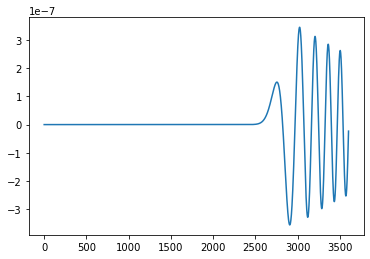

In [88]:
plt.plot(vxSignal)

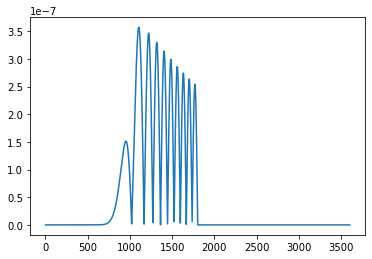

In [92]:
from scipy.fftpack import fft,ifft, fftshift

N=len(vxSignal)

freqs=np.abs(fftshift(vxSignal))
plt.plot(freqs)


I've been messing around with the above 1D model for a little by varying the number of grid points, total run time, and input frequency. The resulting output signals seem to be reasonable, but further experiemntation would likely be necessary.

# 2D EFIT Implementation 

We'll now build upon the 1D implementation to simulate elastic waves in 2D. 

In [95]:
# set Constants:
PoissonRatio = 0.15                                        #poission's ratio in 
YoungModulus = 24 * (10**9)                                #youngs modulus in pascals
mu = YoungModulus/(2*(1+PoissonRatio))                     #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 2400  

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 30000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = .3
BeamHeight = 0.1762
BeamWidth = 0.11

3249.462449572256 2085.144140570748


In [113]:
#Run for n Cycles:
runtime = 15 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegal, omegat) /15)*0.9     #grid step
ts = gs/((max(cl,ct))*(np.sqrt(3)))*0.9 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
gh = int(math.ceil(BeamHeight / gs)) *2
#gw = int(math.ceil(BeamWidth / gs)) *2

print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime(s), time step size(s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts:', gs, gl, gh)
print('Total # of grid pts:',gl*gh)

0.0005 6.668627162714536e-07 0.004170288281141496 751 144 86
runtime(s), time step size(s), total # of time steps: 0.0005 6.668627162714536e-07 751
grid step size, # of length pts, # of height pts: 0.004170288281141496 144 86
Total # of grid pts: 12384


Changing the time step value to the definition of 
$$ \Delta t \le \frac{\Delta x}{c_{max}\sqrt{3}}$$
as defined in chapter 8 of Leckey's book seems to have fixed the overflow errors. Hallalejuha!!!
Moreswork is still needed.

In [114]:
ts1= 1 / frequency / 10
ts2= gs/((max(cl,ct))*(np.sqrt(3)))*.9

print(ts1,ts2)

3.3333333333333333e-06 6.668627162714536e-07


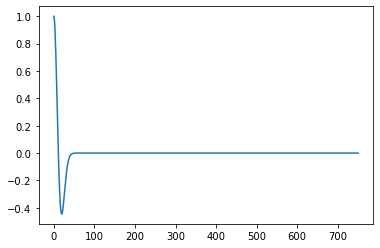

In [115]:
#define ricker excitation function

timeVec=np.linspace(0,runtime,Tsteps)
ricker= lambda fm, t: np.multiply(1-2*np.pi**2*fm**2*np.square(t), np.exp(-np.pi**2*fm**2*np.square(t)))
inputSignal=ricker(frequency,timeVec)

#index locations of excitation
inputLocx=int(gl/2)
inputLocy=int(gh/2)

plt.plot(inputSignal)

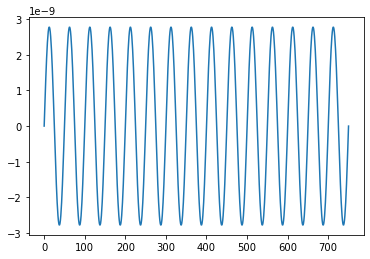

In [116]:
#define sine wave excitation

#radius
r=4
sinInputx=2
sinInputy=int(gh/2)


syyConst=2*ts/(gs*rho)

amp=10
sinConst=ts*amp/rho
sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)

plt.plot(sinInputSignal)

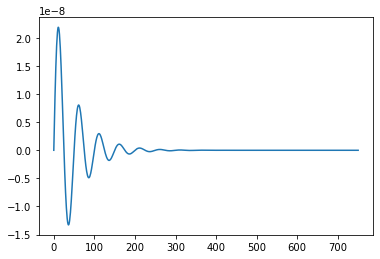

In [117]:
#define sine-exponential wave excitation

#radius
r=3
sinExpInputx=int(gl/2)
sinExpInputy=2



szzConst=2*ts/(gs*rho)

amp=100                     # input amplitude

expConst=30000             #decay rate
sinConst=ts*amp/rho
sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-expConst*timeVec)

plt.plot(sinInputSignal)

In [118]:
#constants
shearConst=(1/gs)*(4/((1/mu)+(1/mu)+(1/mu)+(1/mu)))
velUpdate=2*ts/(rho*gs)
velUpdate2=(1/gs)*(2/(2*rho))

print(shearConst, velUpdate, velUpdate2)

2502172968684.8975 1.3325671818402428e-07 0.09991315673568164


In [119]:
def printMat(mat):
    for i, row in enumerate(mat):
        for col in mat[i]:
            print(col,end='\t')
        print('\n')
    return

In [120]:
#initialize fields
vx=np.zeros((gl,gh))
vy=np.zeros((gl,gh))

sxx=np.zeros((gl,gh))
syy=np.zeros((gl,gh))
sxy=np.zeros((gl,gh))

#record the signal at a specified location
vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
signalLocx=int(gl/2)
signalLocy=3



#time loop
for t in range(0,Tsteps):
    
    #inject excitation function at point
    #vx[inputLocx,inputLocy]=vx[inputLocx,inputLocy]+ts*inputSignal[t]
    
    #inject excitation function as plane wave
    #vx[inputLocx]=vx[inputLocx]+ts*inputSignal[t]
    
    #inject sine wave excitation
    #vy[sinInputx,sinInputy-r:sinInputy+r]=vy[sinInputx,sinInputy-r:sinInputy+r]-syyConst*syy[sinInputx,sinInputy-r:sinInputy+r]+sinInputSignal[t] 
    
    #inject decayig sine exponentail at point
    vy[sinExpInputx,sinExpInputy]=vy[sinExpInputx,sinExpInputy]-syyConst*syy[sinExpInputx,sinExpInputy]+sinInputSignal[t]
    
    #update stresses
    #for x in range(0,gl):
    #    if x==0:
    #        sx[x]=-sx[x+1]
    #    elif x==gl-1:
    #        sx[x]=-sx[x-1]
    #    else:
    #        dsx=(lmbda+2*mu)*(vx[x]-vx[x-1])
    #        sx[x]=sx[x]+ts*dsx
    for x in range(0,gl):
        for y in range(0,gh):
            #corner cases 
            if x==0 and y==0:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x+1,y]
                syy[x,y]=-syy[x,y+1]
                
            elif x==0 and y==gh-1:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x+1,y]
                syy[x,y]=-syy[x,y-1]
                
            elif x==gl-1 and y==0:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x-1,y]
                syy[x,y]=-syy[x,y+1]
                
            elif x==gl-1 and y==gh-1:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x-1,y]
                syy[x,y]=-syy[x,y-1]
            
            #edge cases
            elif x==0 and y!=0 and y!=gh-1:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x+1,y]
                
                dsyy=(1/gs)*((lmbda+2*mu)*(vy[x,y]-vy[x,y-1])+lmbda*(vx[x,y]-vx[x-1,y]))
                syy[x,y]=syy[x,y]+ts*dsyy
            
            elif x!=0 and x!=gl-1 and y==gh-1:
                sxy[x,y]=0
                
                dsxx=(1/gs)*((lmbda+2*mu)*(vx[x,y]-vx[x-1,y])+lmbda*(vy[x,y]-vy[x,y-1]))
                sxx[x,y]=sxx[x,y]+ts*dsxx
                
                syy[x,y]=-syy[x,y-1]
                
            elif x==gl-1 and y!=0 and y!=gh-1:
                sxy[x,y]=0
                sxx[x,y]=-sxx[x-1,y]
                
                dsyy=(1/gs)*((lmbda+2*mu)*(vy[x,y]-vy[x,y-1])+lmbda*(vx[x,y]-vx[x-1,y]))
                syy[x,y]=syy[x,y]+ts*dsyy
                
            elif x!=0 and x!=gl-1 and y==0:
                sxy[x,y]=0
                
                dsxx=(1/gs)*((lmbda+2*mu)*(vx[x,y]-vx[x-1,y])+lmbda*(vy[x,y]-vy[x,y-1]))
                sxx[x,y]=sxx[x,y]+ts*dsxx
                
                syy[x,y]-syy[x,y+1]
                
            #normal update
            else:
                dsxy=shearConst*((vx[x,y+1]-vx[x,y])+(vy[x+1,y]-vy[x,y]))
                sxy[x,y]=sxy[x,y]+ts*dsxy
                
                
                dsxx=(1/gs)*((lmbda+2*mu)*(vx[x,y]-vx[x-1,y])+lmbda*(vy[x,y]-vy[x,y-1]))
                sxx[x,y]=sxx[x,y]+ts*dsxx
                
                dsyy=(1/gs)*((lmbda+2*mu)*(vy[x,y]-vy[x,y-1])+lmbda*(vx[x,y]-vx[x-1,y]))
                syy[x,y]=syy[x,y]+ts*dsyy
                
    
    
    #update velocities
    #for x in range(0,gl):
    #    if x==0:
    #        vx[x]=vx[x]+2*ts/(rho*gs)*sx[x+1]
    #    elif x==gl-1:
    #        vx[x]=vx[x]-2*ts/(rho*gs)*sx[x]
    #    else:
    #        dvx=(1/gs)*(2/(2*rho))*(sx[x+1]-sx[x])
    #        vx[x]=vx[x]+ts*dvx
    for x in range(0,gl):
        for y in range(0,gh):
            #corner cases
            if x==0 and y==0:
                vx[x,y]=vx[x,y]+velUpdate*sxx[x+1,y]
                vy[x,y]=vy[x,y]+velUpdate*syy[x,y+1]
                
            elif x==0 and y==gh-1:
                vx[x,y]=vx[x,y]+velUpdate*sxx[x+1,y]
                vy[x,y]=vy[x,y]-velUpdate*syy[x,y]
                
            elif x==gl-1 and y==0:
                vx[x,y]=vx[x,y]-velUpdate*sxx[x,y]
                vy[x,y]=vy[x,y]+velUpdate*syy[x,y+1]
                
            elif x==gl-1 and y==gh-1:
                vx[x,y]=vx[x,y]-velUpdate*sxx[x,y]
                vy[x,y]=vy[x,y]-velUpdate*syy[x,y]
              
            #edge cases
            elif x==0 and y!=0 and y!=gh-1:
                vx[x,y]=vx[x,y]+velUpdate*sxx[x+1,y]
                
                dvy=velUpdate2*(syy[x,y+1]-syy[x,y])
                vy[x,y]=vy[x,y]+ts*dvy
            
            elif x!=0 and x!=gl-1 and y==gh-1:
                dvx=velUpdate2*(sxx[x+1,y]-sxx[x,y]+sxy[x,y]-sxy[x,y-1]) #added shear stresses to updates at max boundaries
                vx[x,y]=vx[x,y]+ts*dvx
                
                vy[x,y]=vy[x,y]-velUpdate*syy[x,y]
                
            elif x==gl-1 and y!=0 and y!=gh-1:
                vx[x,y]=vx[x,y]-velUpdate*sxx[x,y]
                
                dvy=velUpdate2*(syy[x,y+1]-syy[x,y]+sxy[x,y]-sxy[x-1,y])
                vy[x,y]=vy[x,y]+ts*dvy
                
            elif x!=0 and x!=gl-1 and y==0:
                dvx=velUpdate2*(sxx[x+1,y]-sxx[x,y])
                vx[x,y]=vx[x,y]+ts*dvx
                
                vy[x,y]=vy[x,y]+velUpdate*syy[x,y+1]
            
            #normal
            else:
                dvx=velUpdate2*(sxx[x+1,y]-sxx[x,y]+sxy[x,y]-sxy[x,y-1])
                vx[x,y]=vx[x,y]+ts*dvx
                
                '''
                if x==inputLocx and y==inputLocy:
                    print('----------')
                    #print(dvx,vx[x,y], sxx[x+1,y], sxx[x,y], sxy[x,y], sxy[x,y-1])
                    #printMat(vx[inputLocx:inputLocx+3,inputLocy:inputLocy+3])
                '''
                dvy=velUpdate2*(syy[x,y+1]-syy[x,y]+sxy[x,y]-sxy[x-1,y])
                vy[x,y]=vy[x,y]+ts*dvy
                
    
    #vAbs=np.abs(vx)+np.abs(vy)
    vxSignal[t]=vx[signalLocx,signalLocy]
    vySignal[t]=vy[signalLocx,signalLocy]
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)))
    

0 / 750 checksums vx, sxx: 0.0 0.0
1 / 750 checksums vx, sxx: 2.1686046482465454e-09 0.004882165817527687
2 / 750 checksums vx, sxx: 6.246086987669143e-09 0.013987107391769192
3 / 750 checksums vx, sxx: 9.380945125554124e-09 0.04829592817553222
4 / 750 checksums vx, sxx: 1.1149748227655136e-08 0.0957400558798904
5 / 750 checksums vx, sxx: 1.4486151728433376e-08 0.12899781454955406
6 / 750 checksums vx, sxx: 1.5953279743848357e-08 0.15223243951918908
7 / 750 checksums vx, sxx: 1.9788596414432995e-08 0.1886516831340233
8 / 750 checksums vx, sxx: 2.4752235886995847e-08 0.24736822235112177
9 / 750 checksums vx, sxx: 3.17533108984493e-08 0.2974880706064382
10 / 750 checksums vx, sxx: 3.849851949913485e-08 0.36112441138155826
11 / 750 checksums vx, sxx: 4.389824286549046e-08 0.44464226644546545
12 / 750 checksums vx, sxx: 5.2297241099717466e-08 0.5181617676843432
13 / 750 checksums vx, sxx: 5.753159134925789e-08 0.5832067812302693
14 / 750 checksums vx, sxx: 6.559028593847358e-08 0.659278587

121 / 750 checksums vx, sxx: 1.2615279888822399e-06 9.37903379429444
122 / 750 checksums vx, sxx: 1.2637952173285124e-06 9.410245513026268
123 / 750 checksums vx, sxx: 1.269396397233792e-06 9.437000064205275
124 / 750 checksums vx, sxx: 1.2727674795756046e-06 9.459191132612208
125 / 750 checksums vx, sxx: 1.2764435164086367e-06 9.47855008277925
126 / 750 checksums vx, sxx: 1.2818206677907568e-06 9.504546988318934
127 / 750 checksums vx, sxx: 1.2827706615706757e-06 9.529015135293106
128 / 750 checksums vx, sxx: 1.2888742579307215e-06 9.546500037377934
129 / 750 checksums vx, sxx: 1.2907570163770503e-06 9.557353408923365
130 / 750 checksums vx, sxx: 1.2944476241245285e-06 9.592447348892001
131 / 750 checksums vx, sxx: 1.2975862885514067e-06 9.604324237763928
132 / 750 checksums vx, sxx: 1.3011473934483053e-06 9.630952085766854
133 / 750 checksums vx, sxx: 1.3053429242280576e-06 9.661570473010604
134 / 750 checksums vx, sxx: 1.3088526154849645e-06 9.689755024203734
135 / 750 checksums vx,

239 / 750 checksums vx, sxx: 1.912561371460598e-06 12.772529083377368
240 / 750 checksums vx, sxx: 1.9038391647724674e-06 12.85174243274869
241 / 750 checksums vx, sxx: 1.880796049655559e-06 12.928766228767223
242 / 750 checksums vx, sxx: 1.8652101299874796e-06 13.039286114130604
243 / 750 checksums vx, sxx: 1.8447141155423236e-06 13.102649535459566
244 / 750 checksums vx, sxx: 1.82826757121792e-06 13.175770334890679
245 / 750 checksums vx, sxx: 1.8172923395080934e-06 13.216934415028472
246 / 750 checksums vx, sxx: 1.8125133088542764e-06 13.24313196208469
247 / 750 checksums vx, sxx: 1.8161318965327455e-06 13.275403320658285
248 / 750 checksums vx, sxx: 1.8245216894723213e-06 13.253501262320423
249 / 750 checksums vx, sxx: 1.8415003566812547e-06 13.246924659200015
250 / 750 checksums vx, sxx: 1.8654153607105528e-06 13.142841873976685
251 / 750 checksums vx, sxx: 1.8897692587086182e-06 13.087364053889821
252 / 750 checksums vx, sxx: 1.926404561947946e-06 12.974553193072415
253 / 750 che

356 / 750 checksums vx, sxx: 2.8791106910660656e-06 16.192889001166577
357 / 750 checksums vx, sxx: 2.889564064829619e-06 16.3261664083618
358 / 750 checksums vx, sxx: 2.8930006644140415e-06 16.458500970607453
359 / 750 checksums vx, sxx: 2.8971817449507198e-06 16.57682179176922
360 / 750 checksums vx, sxx: 2.8981359204624754e-06 16.66883122629614
361 / 750 checksums vx, sxx: 2.8948386593676203e-06 16.69949695524085
362 / 750 checksums vx, sxx: 2.8963526627663907e-06 16.70108651994896
363 / 750 checksums vx, sxx: 2.8895726219827182e-06 16.689462917926228
364 / 750 checksums vx, sxx: 2.8955925651497295e-06 16.663001643924364
365 / 750 checksums vx, sxx: 2.898370933453212e-06 16.626256330313446
366 / 750 checksums vx, sxx: 2.9105095315804317e-06 16.585588397132074
367 / 750 checksums vx, sxx: 2.9217796902539197e-06 16.53809623414832
368 / 750 checksums vx, sxx: 2.9283871223602595e-06 16.471525822296556
369 / 750 checksums vx, sxx: 2.9405968047284213e-06 16.388676789881924
370 / 750 check

473 / 750 checksums vx, sxx: 3.343601962136183e-06 19.977149138664434
474 / 750 checksums vx, sxx: 3.3290781437225916e-06 20.03668371248146
475 / 750 checksums vx, sxx: 3.3059038469186603e-06 20.109549937573586
476 / 750 checksums vx, sxx: 3.278425977630165e-06 20.18159708716751
477 / 750 checksums vx, sxx: 3.2451567523785806e-06 20.26034011114613
478 / 750 checksums vx, sxx: 3.228262507821634e-06 20.3477523220875
479 / 750 checksums vx, sxx: 3.2241003174681483e-06 20.453937816993506
480 / 750 checksums vx, sxx: 3.2289777076070944e-06 20.555869548520093
481 / 750 checksums vx, sxx: 3.2358079337893833e-06 20.648827642941335
482 / 750 checksums vx, sxx: 3.2440877410943598e-06 20.715665054340636
483 / 750 checksums vx, sxx: 3.252004291525933e-06 20.739628888085633
484 / 750 checksums vx, sxx: 3.254691114835256e-06 20.72301841136004
485 / 750 checksums vx, sxx: 3.2546111938128225e-06 20.675491573707767
486 / 750 checksums vx, sxx: 3.2527161459150343e-06 20.607949341396413
487 / 750 checksu

591 / 750 checksums vx, sxx: 3.5211958087464405e-06 22.66078667645236
592 / 750 checksums vx, sxx: 3.442805316777593e-06 23.06033253714748
593 / 750 checksums vx, sxx: 3.3614661852978866e-06 23.40604821748375
594 / 750 checksums vx, sxx: 3.280107198539241e-06 23.751928894624967
595 / 750 checksums vx, sxx: 3.217721291271409e-06 24.053331755146857
596 / 750 checksums vx, sxx: 3.1744795520389273e-06 24.295339116172176
597 / 750 checksums vx, sxx: 3.152474550111699e-06 24.470649553662863
598 / 750 checksums vx, sxx: 3.1551031718379403e-06 24.5652938621488
599 / 750 checksums vx, sxx: 3.1713422216186205e-06 24.573970623381673
600 / 750 checksums vx, sxx: 3.2092891519354577e-06 24.48834125003983
601 / 750 checksums vx, sxx: 3.260256272637531e-06 24.325634021706968
602 / 750 checksums vx, sxx: 3.3347625244139923e-06 24.11376831758094
603 / 750 checksums vx, sxx: 3.4138394414478632e-06 23.849977874431946
604 / 750 checksums vx, sxx: 3.4947386543112346e-06 23.570281208866092
605 / 750 checksum

709 / 750 checksums vx, sxx: 3.934674795587976e-06 28.76386975459581
710 / 750 checksums vx, sxx: 3.943694824085348e-06 29.055193898947284
711 / 750 checksums vx, sxx: 3.965095630604397e-06 29.35426668965104
712 / 750 checksums vx, sxx: 3.9928764505806905e-06 29.644699112962538
713 / 750 checksums vx, sxx: 4.023345440572507e-06 29.854351124564317
714 / 750 checksums vx, sxx: 4.059138337899891e-06 29.9991867035649
715 / 750 checksums vx, sxx: 4.097736798661982e-06 30.088193831163636
716 / 750 checksums vx, sxx: 4.132225033362676e-06 30.15405873939932
717 / 750 checksums vx, sxx: 4.156382299962286e-06 30.194885668322488
718 / 750 checksums vx, sxx: 4.16744919522373e-06 30.254432552517912
719 / 750 checksums vx, sxx: 4.163196899862633e-06 30.363179101387004
720 / 750 checksums vx, sxx: 4.144507815418074e-06 30.523757600372605
721 / 750 checksums vx, sxx: 4.120806281416855e-06 30.755350797985745
722 / 750 checksums vx, sxx: 4.09067817611727e-06 31.031528268801566
723 / 750 checksums vx, sx

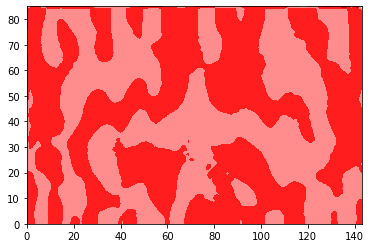

In [124]:
plt.contourf(np.transpose(vy),cmap='seismic')

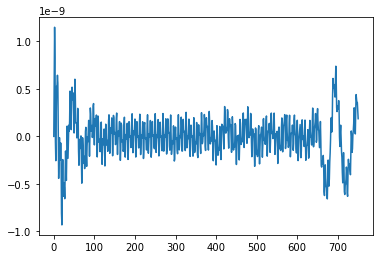

In [125]:
plt.plot(vxSignal)

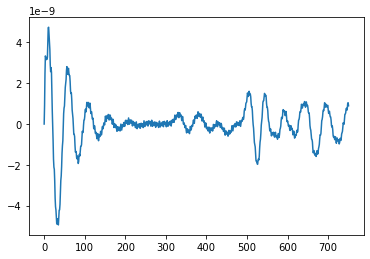

In [126]:
plt.plot(vySignal)

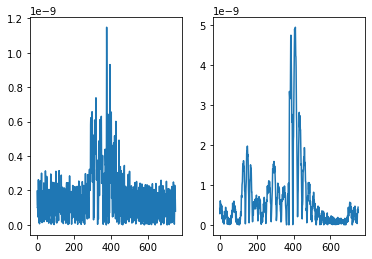

In [128]:
from scipy.fftpack import fft,ifft, fftshift

N=len(vxSignal)



fig, (ax1,ax2)=plt.subplots(1,2)

freqs=np.abs(fftshift(vxSignal))
ax1.plot(freqs)

freqs=np.abs(fftshift(vySignal))
ax2.plot(freqs)


# 3D Implementation



In [46]:
# set Constants:
PoissonRatio = 0.15                                        #poission's ratio in 
YoungModulus = 24 * (10**9)                                #youngs modulus in pascals
mu = YoungModulus/(2*(1+PoissonRatio))                     #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 2400                                                 #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
BeamLength = .15
BeamWidth = 0.15
BeamHeight = 0.1

3249.462449572256 2085.144140570748


In [186]:
#Run for n Cycles:
runtime = 4 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegal, omegat) /10)    #grid step
ts = gs/((max(cl,ct))*(np.sqrt(3)))*0.95 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl = int(math.ceil(BeamLength / gs)) *2       #length 
gw = int(math.ceil(BeamWidth / gs)) *2        #width
gh = int(math.ceil(BeamHeight / gs)) *2       #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime(s), time step size(s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl,gw,gh)
print('Total # of pts:', gl*gw*gh)

runtime(s), time step size(s), total # of time steps: 0.0001 8.798883061915012e-07 115
grid step size, # of length pts, # of height pts, # of width pts: 0.005212860351426869 58 58 40
Total # of pts: 134560


In [187]:
#constants for updates
norm1=(lmbda+2*mu)/gs
norm2=lmbda/gs
shearConst=(1/gs)*(4/((1/mu)+(1/mu)+(1/mu)+(1/mu)))
vel1=2*ts/(rho*gs)
vel2=(1/gs)*(2/(2*rho))
             
print(norm1,norm2, shearConst, vel1,vel2)

4861364624873.516 857887874977.6791 2001738374947.918 1.4065986919424786e-07 0.07993052538854532


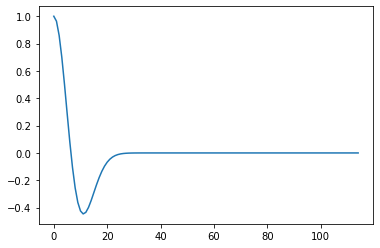

In [188]:
#define ricker excitation function

timeVec=np.linspace(0,runtime,Tsteps)
ricker= lambda fm, t: np.multiply(1-2*np.pi**2*fm**2*np.square(t), np.exp(-np.pi**2*fm**2*np.square(t)))
inputSignal=ricker(frequency,timeVec)

#index locations of excitation
inputLocx=int(gl/2)
inputLocy=2
inputLocz=2

plt.plot(inputSignal)

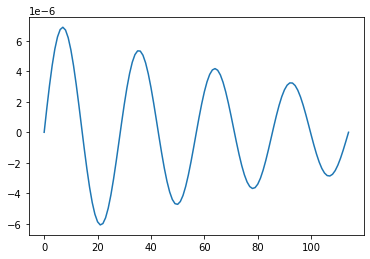

In [189]:
#define sine-exponential wave excitation

#radius
r=3
sinInputx=2
sinInputy=int(gw/3)
sinInputz=int(gh/2)


szzConst=2*ts/(gs*rho)

amp=20000
sinConst=ts*amp/rho
sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-10000*timeVec)

plt.plot(sinInputSignal)

In [195]:
#boundary values 
xmax=gl-1
ymax=gw-1
zmax=gh-1

#initialize fields
vx=np.zeros((gl,gw,gh))
vy=np.zeros((gl,gw,gh))
vz=np.zeros((gl,gw,gh))
#the entries in the stress tensor are indexed as:
#x,y,z position and sxx,syy,szz,sxy,sxz,syz
sxx=np.zeros((gl,gw,gh))
syy=np.zeros((gl,gw,gh))
szz=np.zeros((gl,gw,gh))
sxy=np.zeros((gl,gw,gh))
sxz=np.zeros((gl,gw,gh))
syz=np.zeros((gl,gw,gh))

#record the signal at a specified location
vxSignal=np.zeros(Tsteps)
signalLocx=int(gl/2)
signalLocy=int(gw/4)
signalLocz=int(gh/2)

vxSignal=np.zeros(Tsteps)

for t in range(0,Tsteps):
    
    #inject excitation at single point
    #vz[inputLocx,inputLocy,inputLocz]=vz[inputLocx,inputLocy,inputLocz]-((2*ts)/(gs*rho))*szz[inputLocx,inputLocy,inputLocz]+(ts/rho)*inputSignal[t]
        
    #plane wave excitation
    #vz[inputLocz]=vz[inputLocz]-((2*ts)/(gs*rho))*szz[inputLocz]+(ts/rho)*inputSignal[t]
    
    #sin-exponential input
    #vz[sinInputx,sinInputy,sinInputz-r:sinInputz+r]=vz[sinInputx,sinInputy,sinInputz-r:sinInputz+r]-szzConst*szz[sinInputx,sinInputy,sinInputz-r:sinInputz+r]+sinInputSignal[t]
    
    #plane wave sin-exponential
    vz[sinInputx,sinInputy,:]=vz[sinInputx,sinInputy,:]-szzConst*szz[sinInputx,sinInputy,:]+sinInputSignal[t]
    
    
    
    #update Stresses
    for x in range(gl):
        for y in range(gw):
            for z in range(gh):
                #FACES
                if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    ds=shearConst*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
                    sxy[x,y,z]=sxy[x,y,z]+ds*ts
                    
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:
                    sxx[x,y,x]=-sxx[x+1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    
                    ds=shearConst*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
                    syz[x,y,z]=syz[x,y,z]+ds*ts
                    
                elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    
                    ds=shearConst*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
                    syz[x,y,z]=syz[x,y,z]+ds*ts
                    
                elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    
                    ds=shearConst*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
                    sxz[x,y,z]=sxz[x,y,z]+ds*ts
                    
                    syz[x,y,z]=0
                    
                elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    
                    ds=shearConst*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
                    sxz[x,y,z]=sxz[x,y,z]+ds*ts
                    
                    syz[x,y,z]=0
                    
                elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    ds=shearConst*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
                    sxy[x,y,z]=sxy[x,y,z]+ds*ts
                    
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                #EDGES
                #bottom edges
                elif x==0 and y!=0 and y!=ymax and z==0:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y!=0 and y!=ymax and z==0:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                elif x!=0 and x!=xmax and y==0 and z==0:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                elif x!=0 and x!=xmax and y==ymax and z==0:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                #side edges
                elif x==0 and y==0 and z!=0 and z!=zmax:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                elif x==xmax and y==0 and z!=0 and z!=zmax:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==0 and y==ymax and z!=0 and z!=zmax:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                elif x==xmax and y==ymax and z!=0 and z!=zmax:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                #top edges
                elif x==0 and y!=0 and y!=ymax and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y!=0 and y!=ymax and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x!=0 and x!=xmax and y==0 and z==zmax:
                    
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                elif x!=0 and x!=xmax and y==ymax and z==zmax:
                    
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                    
                #CORNERS
                
                elif x==0 and y==0 and z==0:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==0 and y==0 and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==0 and y==ymax and z==0:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==0 and y==ymax and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x+1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y==0 and z==0:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y==0 and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y+1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y==ymax and z==0:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z+1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                elif x==xmax and y==ymax and z==zmax:
                    
                    sxx[x,y,z]=-sxx[x-1,y,z]
                    
                    syy[x,y,z]=-syy[x,y-1,z]
                    
                    szz[x,y,z]=-szz[x,y,z-1]
                    
                    sxy[x,y,z]=0
                    sxz[x,y,z]=0
                    syz[x,y,z]=0
                    
                #NORMAL UPDATE
                else:
                    
                    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
                    sxx[x,y,z]=sxx[x,y,z]+ds*ts
                    
                    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
                    syy[x,y,z]=syy[x,y,z]+ds*ts
                    
                    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
                    szz[x,y,z]=szz[x,y,z]+ds*ts
                    
                    ds=shearConst*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
                    sxy[x,y,z]=sxy[x,y,z]+ds*ts

                    ds=shearConst*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
                    sxz[x,y,z]=sxz[x,y,z]+ds*ts   
                
                    ds=shearConst*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
                    syz[x,y,z]=syz[x,y,z]+ds*ts

                    
    

    #update Velocities
    for x in range(gl):
        for y in range(gw):
            for z in range(gh):
                #FACES
                if x!=0 and x!=xmax and y!=0 and y!=ymax and z==0:
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                    
                elif x==0 and y!=0 and y!=ymax and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts

                    
                elif x==xmax and y!=0 and y!=ymax and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
                    
                elif x!=0 and x!=xmax and y==0 and z!=0 and z!=zmax:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
                    
                   
                elif x!=0 and x!=xmax and y==ymax and z!=0 and z!=zmax:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts                     
                    
                    
                elif x!=0 and x!=xmax and y!=0 and y!=ymax and z==zmax:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]

                    
                    
                #EDGES
                #bottom edges
                elif x==0 and y!=0 and y!=ymax and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                   
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x==xmax and y!=0 and y!=ymax and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x!=0 and x!=xmax and y==0 and z==0:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x!=0 and x!=xmax and y==ymax and z==0:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                #side edges
                elif x==0 and y==0 and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts

                elif x==xmax and y==0 and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
                    
                    
                elif x==0 and y==ymax and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
                    
                    
                    
                elif x==xmax and y==ymax and z!=0 and z!=zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
                    
                                        
                #top edges
                elif x==0 and y!=0 and y!=ymax and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                    
                elif x==xmax and y!=0 and y!=ymax and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
                    
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                elif x!=0 and x!=xmax and y==0 and z==zmax:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                    
                elif x!=0 and x!=xmax and y==ymax and z==zmax:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
                    
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                 
                #CORNERS
                elif x==0 and y==0 and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x==0 and y==0 and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                elif x==0 and y==ymax and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x==0 and y==ymax and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]+vel1*sxx[x+1,y,z]
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                elif x==xmax and y==0 and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x==xmax and y==0 and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    vy[x,y,z]=vy[x,y,z]+vel1*syy[x,y+1,z]
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                elif x==xmax and y==ymax and z==0:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    vz[x,y,z]=vz[x,y,z]+vel1*szz[x,y,z+1]
                    
                elif x==xmax and y==ymax and z==zmax:
                    
                    vx[x,y,z]=vx[x,y,z]-vel1*sxx[x,y,z]
                    vy[x,y,z]=vy[x,y,z]-vel1*syy[x,y,z]
                    vz[x,y,z]=vz[x,y,z]-vel1*szz[x,y,z]
                    
                else:
                    
                    dv=vel2*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
                    vx[x,y,z]=vx[x,y,z]+dv*ts
    
                    dv=vel2*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
                    vy[x,y,z]=vy[x,y,z]+dv*ts
    
                    dv=vel2*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
                    vz[x,y,z]=vz[x,y,z]+dv*ts
    
    #record signal
    vxSignal[t]=vx[signalLocx,signalLocy,signalLocz]
    
    
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)))
    
    if t%10==0 and t<100:
        fig=plt.figure()
        plt.contourf(vz[:,:,int(gh/2)], cmap='seismic')
        plt.savefig('savedFigs/EFIT3D/vzMidcut0'+str(t)+'.png')
        plt.close(fig)
    elif t%10==0 and t>=100:
        fig=plt.figure()
        plt.contourf(vz[:,:,int(gh/2)], cmap='seismic')
        plt.savefig('savedFigs/EFIT3D/vzMidcut'+str(t)+'.png')
        plt.close(fig)
    

0 / 114 checksums vx, sxx: 0.0 0.0
1 / 114 checksums vx, sxx: 7.875588158358461e-07 0.0
2 / 114 checksums vx, sxx: 3.224253718976229e-06 10.304410746542018
3 / 114 checksums vx, sxx: 8.03355241243773e-06 40.54164856240368
4 / 114 checksums vx, sxx: 1.5625308754950125e-05 95.94954397986677
5 / 114 checksums vx, sxx: 2.7892735055480767e-05 175.67218917322188
6 / 114 checksums vx, sxx: 4.0449096406022066e-05 277.0685889060349
7 / 114 checksums vx, sxx: 5.616720810843288e-05 410.8771782606524
8 / 114 checksums vx, sxx: 7.300267804763571e-05 570.1438538976497
9 / 114 checksums vx, sxx: 9.336758271475403e-05 771.3040865981676
10 / 114 checksums vx, sxx: 0.00012439464218844793 999.578250475221
11 / 114 checksums vx, sxx: 0.0001599561521950195 1235.3585245145523
12 / 114 checksums vx, sxx: 0.0002054665706862108 1453.9412071438662
13 / 114 checksums vx, sxx: 0.00025726062194254785 1676.3888470791628
14 / 114 checksums vx, sxx: 0.000311288351948801 1929.5128620272255
15 / 114 checksums vx, sxx: 

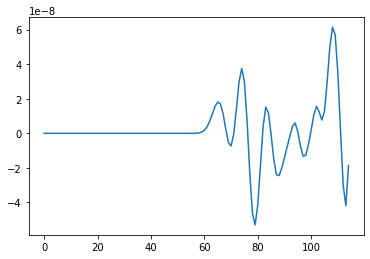

In [201]:
plt.plot(vxSignal)

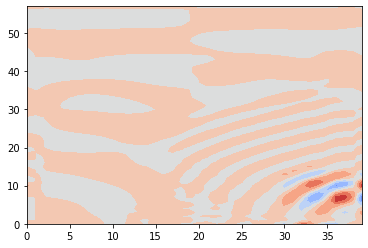

In [205]:
plt.contourf(vx[:,int(gw/2),:], cmap='coolwarm')

In [99]:
#testing out how to make animated gif from saved EFIT figures

import glob

from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/efitAnim.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)
    

In [100]:
frame_folder='savedFigs/EFIT3D'

make_gif(frame_folder)

In [805]:
vxmax=np.max(np.absolute(vx))
vymax=np.max(np.absolute(vy))
vzmax=np.max(np.absolute(vz))

print(vxmax,vymax,vzmax)

7.974850052570108e-11 7.974850052570106e-11 2.338538147940619e-10


In [806]:
sxxmax=np.max(np.absolute(sxx))
syymax=np.max(np.absolute(syy))
szzmax=np.max(np.absolute(szz))
sxymax=np.max(np.absolute(sxy))
sxzmax=np.max(np.absolute(sxz))
syzmax=np.max(np.absolute(syz))

print(sxxmax,syymax,szzmax,sxymax,sxzmax,syzmax)

0.01319125666246403 0.013191256662464028 0.0023252138536548725 0.005611761130034561 0.0023634958587999077 0.00236349585879991


In [647]:
ind=np.where(sxxCut==np.max(sxxCut))

In [651]:
ind

(array([88], dtype=int64), array([0], dtype=int64))

In [652]:
sxxCut[88,0]

0.21483310914625062

In [26]:
frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]

np.shape(frames)

(26,)

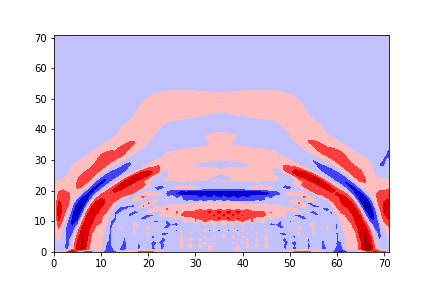

# experimenting with different material geometries

In [222]:
# set Constants

#MATERIAL 1 (concrete)
pRatio1 = 0.2                                     #poission's ratio 
yModulus1 = 30 * (10**9)                           #youngs modulus in pascals
rho1 = 2300                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter


#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)
print('-----                   Longitudinal   |  Transverse ')
print('material 1 wave speeds:' ,cl1,ct1)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency




#MATERIAL 2 (iron)
pRatio2=0.25
yModulus2= 200*(10**9)
rho2 = 7900       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = 2 * mu2 * pRatio2 / (1 - 2 * pRatio2)     

#Calculate speed of longitudinal and transverse waves in material 2
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency


#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2

#dimensions of material 1 
length1 = 0.15
width1 = 0.15
height1 = 0.15

#dimensions for material 2
length2= 0.05
width2= 0.05
height2= 0.05



-----                   Longitudinal   |  Transverse 
material 1 wave speeds: 3806.934938134405 2331.2620206007846
material 2 wave speeds: 5511.782546095505 3182.22913670292


In [223]:
#Run for n Cycles:
runtime = 8 / frequency 

#Set time step and grid step to satisfy courant conditions

gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /40)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.95  #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) *2       #length 
gw1 = int(math.ceil(width1 / gs)) *2        #width
gh1 = int(math.ceil(height1 / gs)) *2       #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl1, gw1,gh1)


runtime (s), time step size (s), total # of time steps: 0.0002 1.4499132162492646e-07 1381
grid step size, # of length pts, # of height pts, # of width pts: 0.0014570387628754903 206 206 206


In [220]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#circular cylinder

#x,y position of cylinder center
locx=int(gl1/2)
locy=int(gw1/2)

#radius of cylinder in meters
cr=length1/1.25

for x in range(0,gl1):
    for y in range(0,gw1):
        
        #does (x,y) lie within cylinder
        xcoor=(gs*x-gs*locx)**2
        ycoor=(gs*y-gs*locy)**2
        
        if np.sqrt(xcoor+ycoor)<cr:
            matProps[0,x,y,:]=rho2
            matProps[0,x,y,:]=lmbda2
            matProps[0,x,y,:]=mu2



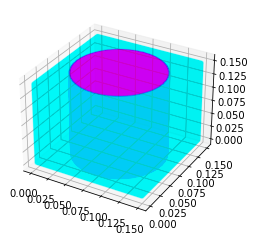

In [221]:
#3D scatter plot of grid pts to show geometry 
#of the 2 materials

x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matProps[0,:,:,:]

plt.figure()


ax=plt.axes(projection='3d')

fig=ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')

In [179]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#sphere

#x,y position of sphere center
locx=int(gl1/2)
locy=int(gw1/2)
locz=int(gh1/2)

#radius of sphere in meters
sr=length1/4

for x in range(0,gl1):
    for y in range(0,gw1):
        for z in range(0,gh1):
            
            #does (x,y,z) lie within sphere
            xcoor=(gs*x-gs*locx)**2
            ycoor=(gs*y-gs*locy)**2
            zcoor=(gs*z-gs*locz)**2
        
            if np.sqrt(xcoor+ycoor+zcoor)<sr:
                matProps[0,x,y,z]=rho2
                matProps[0,x,y,z]=lmbda2
                matProps[0,x,y,z]=mu2



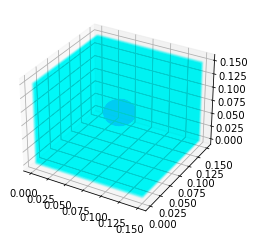

In [180]:
#3D scatter plot of grid pts to show geometry 
#of the 2 materials

x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matProps[0,:,:,:]

plt.figure()


ax=plt.axes(projection='3d')

fig=ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')

In [161]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1

#elliptic cylinder

#x,y position of cylinder center
locx=int(gl1/2)
locy=int(gw1/2)

#radius of cylinder in meters
a=length1/2
b=width1/1.25

for x in range(0,gl1):
    for y in range(0,gw1):
        
        #does (x,y) lie within cylinder
        xcoor=(1/a**2)*(gs*x-gs*locx)**2
        ycoor=(1/b**2)*(gs*y-gs*locy)**2
        
        if np.sqrt(xcoor+ycoor)<1:
            matProps[0,x,y,:]=rho2
            matProps[0,x,y,:]=lmbda2
            matProps[0,x,y,:]=mu2



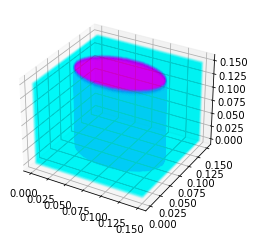

In [162]:
#3D scatter plot of grid pts to show geometry 
#of the 2 materials

x=np.linspace(0,length1,gl1)
y=np.linspace(0,width1,gw1)
z=np.linspace(0,height1,gh1)

X, Y, Z = np.meshgrid(x, y, z)

U=matProps[0,:,:,:]

plt.figure()


ax=plt.axes(projection='3d')

fig=ax.scatter3D(X,Y,Z,c=U, alpha=0.02, marker='.', cmap='cool')